# 4. Epidemic likelihoods 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/04-epidemic-likelihoods.ipynb)

**Date**: Tuesday Sept 10, 2024

In this session, we expand on the previous material by looking at likelihood functions for epidemic models.

## Learning outcomes
- Mathematical specification of likelihood functions for (continuous and discrete time) epidemic models
- Time slicing likelihood formulation
- Iterative implemenation of evaluation
- Maximum likelihood parameter estimation for simulated data


---
## Theory

Epidemic models belong to a broader class of models called *state transition* models where units are categorized into a finite set of model states. These models aim to describe the progression of an underlying epidemic process. State transition models are used in other research areas as well such as queuing theory, clinical trails history, and reliability engineering.

Epidemic processes are naturally counting processes since the main object of interest is the number of units that are in each model state. Mathematically, these types of processes are known as *Poisson processes*. We define a Poisson process over a fixed time period $[0, t_{max})$ during which we are counting the number of events that occur. There are several important properties about these processes that help with formulating the likelihood.

1. **Independence** The number of events that occur in disjoint intervals of time are independent. For example, if we partition the time period into $[0, \frac{t_{max} }{ 2 }) \cup [\frac{t_{max} }{ 2 }, t_{max})$, the number of events occurring in each subset is independent of the other.
2. **Exponential wait times** The waiting time between consecutive events in a Poisson process follows an exponential distribution. This means the waiting time until the next event is memoryless, and the likelihood of an event occurring soon after the previous event is the same as if we had just started observing.
3. **Stationarity** The probability of an event occuring in a time interval depends only on the length of the time interval. In other words, we assume that the event rate $\lambda$ is constant over a time interval.

The stationarity condition might initially seem strong, it does help distinguish between two types of Poisson processes. The first is a time *homogeneous process* where the event rate $\lambda$ is constant over time. The second is a time *inhomogeneous process* where the event rate $λ(t)$ varies over time. We make this clear by indicating $\lambda(t)$ a function of time (and not a constant).

Epidemic models such as the SIR model are great examples of a time inhomogeneous Poisson process. The event rates often depend on the number of units in each state of the model (eg. frequency or density dependent transmission rate functions). This means that as units transition between states, the event rates will change accordingly making this an inhomogeneous process.



### Likelihood function of the SIR model
Suppose we define a Susceptible-Infected-Removed model graphically as shown below.

In [ ]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!apt install amsmath

!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,149 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,224 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https

In [ ]:
# @title
%load_ext tikzmagic

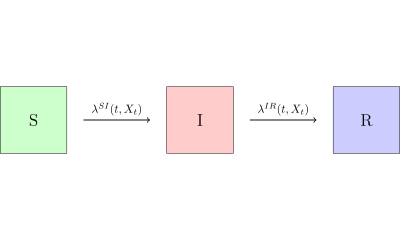

In [ ]:
# @title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=green!20!white, draw=black] (0,0) rectangle node{\Large S} (2,2) ;

\draw[thick,->] (2.5,1) -- node[anchor = south]{$\lambda^{SI}(t, X_t)$} (4.5, 1) ;

\filldraw[fill=red!20!white, draw=black] (5,0) rectangle node{\Large I}(7,2);

\draw[thick,->] (7.5,1) -- node[anchor = south]{$\lambda^{IR}(t, X_t)$} (9.5, 1) ;

\filldraw[fill=blue!20!white, draw=black] (10,0) rectangle node{\Large R} (12,2);

In this model, there are two transition events that can occur.

1. $S → I$ - infection event
2. $I → R$ - removal event

Each of these is itself a time inhomogeneous Poisson process which makes the SIR model a time inhomogeneous Poisson process (the sum of Poisson processes is itself a Poisson process - proof can be done with moment generating function but not important for this course). To write out the likelihood function, we take advantage of the independence property and exponentially distributed wait times property.

Suppose that observations (or data) are over a time period $[0 ,t_{max})$ as before. We can partition this period into smaller (left closed-right open) intervals such that each interval contains *only* 1 event. Set the length of each interval as $\delta t_i= t_{s+1}- t_s$ and then
\begin{equation}
[0 ,t_{max}) = \bigcup_{s \in = 0,\ldots, max-1} [t_s, t_{s+1})
\end{equation}
Recall that in each time interval, the wait time until the next event is exponentially distributed with a constant rate. For SIR model, we define the infection rate as $\lambda^{SI}(t)$ and the removal rate as $\lambda^{IR}(t)$. Let $z^{SI}, z^{IR}$ be the number of infection and removal events respectively since time $t=0$. Then, for any time interval, the probability of observing each event is
\begin{align}
\delta_{t_s}^{SI}&\sim \mbox{Exponential}(\lambda^{SI}(t_s)) \\
\delta_{t_s}^{IR}&\sim \mbox{Exponential}(\lambda^{IR}(t_s)) \\
\Rightarrow P(z^{SI}_{t_s + \delta t_s} - z^{SI}_{t_s} = 1 | z^{SI}_{t_s}) &= 1 -  e^{-\lambda^{SI}(t_s)\delta_{t_s}} \\
\Rightarrow P(z^{IR}_{t_s + \delta t_s} - z^{IR}_{t_s} = 1 | z^{IR}_{t_s}) &= 1 -  e^{-\lambda^{IR}(t_s)\delta_{t_s}}
\end{align}
In contrast, the probability that an event did *not* occur in that time window can be evaluated with the accompanying survival function.
\begin{align}
P(z^{SI}_{t_s + \delta t_s} - z^{SI}_{t_s} = 0) &= e^{-\lambda^{SI}(t_s)\delta t_s} \\
P(z^{IR}_{t_s + \delta t_s} - z^{IR}_{t_s} = 0) &= e^{-\lambda^{IR}(t_s)\delta t_s}
\end{align}
Therefore, the likelihood that an infection event occured in a time interval is
\begin{align}
P(S \rightarrow I, \delta t_s| H_t) &= \lambda^{SI}(t_s) e^{-\lambda^{SI}(t_i) \delta t_s} e^{-\lambda^{IR}(t_i) \delta t_s} \\
&= \lambda^{SI}(t_s) e^{ - \left(\lambda^{SI}(t_i)+\lambda^{IR}(t_s)\right)\delta t_s}
\end{align}
Similarly for the likeihood of a removal event
\begin{align}
P(I \rightarrow R, \delta t_s| H_t) &= \lambda^{IR}(t_s) e^{-\lambda^{IR}(t_s) \delta t_s} e^{-\lambda^{SI}(t_s) \delta t_s} \\
&= \lambda^{IR}(t_s) e^{ -\left(\lambda^{SI}(t_s)+\lambda^{IR}(t_s)\right) \delta t_s}
\end{align}
Since each time interval is independent of the other, we can get the likelihood of the entire process by taking the product over all time intervals
\begin{equation}
L(X|H) = \prod_{s=0}^{max - 1} \lambda(t_s) e^{ -\left(\lambda^{SI}(t_s)+\lambda^{IR}(t_s)\right) \delta t_s}
\end{equation}
\begin{equation}
l(X|H) = \sum_{s=0}^{max - 1} \log\lambda(t_s) - \sum_{s=0}^{max - 1}\left(\lambda^{SI}(t_s)+\lambda^{IR}(t_s)\right) \delta t_s
\end{equation}
For convenience, we drop the superscript on the event occurred (the $\lambda (t)$ which is not part of the expontential because it is clear that it indicates the rate of the transition event that occurred.

## Practice

### Exercise 1
Consider the data generated by SIR model with following transition rates.

\begin{equation}
\left\{\begin{array}{lr}
        \lambda^{SI} (t) = 0.005 S(t)I(t) & \mbox{infectious pressure in system}\\
        \lambda^{IR}_i (t) = 0.02 I(t) & \mbox{removal pressure in system} \\
        0 & \text{o.w.}
        \end{array}\right.
\end{equation}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
unit_id = np.arange(0,3)
infection_times = np.array([0.0, 4., 2.])
removal_times = np.array([3., 6., 8.])

ex1_data = pd.DataFrame({'unit_id': unit_id,
                        'infection_time': infection_times,
                        'removal_time': removal_times}
                        )
ex1_data

,unit_id,infection_time,removal_time
0,0,0.0,3.0
1,1,4.0,6.0
2,2,2.0,8.0


In [ ]:
# convert to array for plotting
ex1_data = np.array(ex1_data)

[]

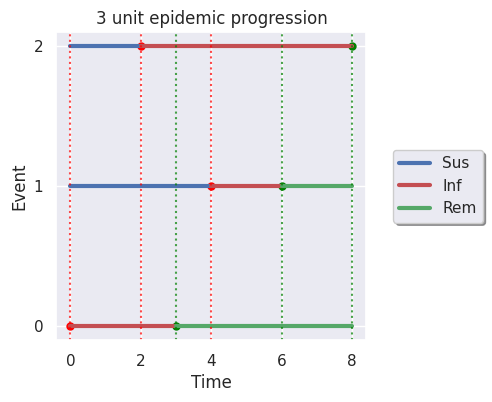

In [ ]:
# @title
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

pop_size = 3

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()

ax.scatter(ex1_data[:,1], ex1_data[:,0], color='red', s=25)
ax.scatter(ex1_data[:,2], ex1_data[:,0], color='green', s=25)

plt.yticks(np.arange(pop_size))

# plot susceptible period
for ii in range(pop_size):
    x = [0, ex1_data[ii,1]]
    y = [ii, ii]
    ax.plot(x,y,'b-',alpha=1, linewidth=3, label = 'Sus')

# plot infective period
for ii in range(pop_size):
    x = [ex1_data[ii,1], ex1_data[ii,2]]
    y = [ii, ii]
    ax.plot(x,y,'r-',alpha=1, linewidth=3, label = 'Inf')
    #ax.text(x, y, f" {ii}", color='red')

# plot removed period
for ii in range(pop_size):
    x = [ex1_data[ii,2], np.max(ex1_data[:,2])]
    y = [ii, ii]
    ax.plot(x,y,'g-',alpha=1, linewidth=3, label = 'Rem')
    #ax.text(x, y, f" {ii}", color='red')

legend_elements = [Line2D([0], [0], color='b', lw=3, label='Sus'),
                   Line2D([0], [0], color='r', lw=3, label='Inf'),
                   Line2D([0], [0], color='g', lw=3, label='Rem'),
                   ]

# plot horizontal dashed lines at each event
for ii in range(pop_size):
    plt.axvline(x=ex1_data[ii,1], linestyle = 'dotted', color = 'red', alpha = 0.7)
    plt.axvline(x=ex1_data[ii,2], linestyle = 'dotted', color = 'green', alpha = 0.7)

plt.xlabel('Time')
plt.ylabel('Event')
plt.title(f'{pop_size} unit epidemic progression')

plt.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.4, .5),
          ncol=1, fancybox=True, shadow=True)
ax.plot()

__Question__

Compute the log-likelihood of the first event (i.e. unit 2 undergoing an infection event) occuring after the first time-slice.



### Solution:
At $t=0$, there is 1 infected unit and 2 susceptible units. We can then compute the transition rates for each of unit.

In [ ]:
# constants
beta = 0.005
gamma = 0.02

S_0 = 2
I_0 = 1
R_0 = 0

def transition_rate_fn(S,I,R):
    # si rate
    si_rate = beta*S*I
    # ir rate
    ir_rate = gamma*I
    return si_rate, ir_rate

# transition rates
transition_rates = transition_rate_fn(S_0, I_0, R_0)

# time delta
delta_t = 2. - 0

In [ ]:
# likelihood follows from L(X|D) formula
print(f"L(X|D) = {transition_rates[0]*np.exp(- np.sum(transition_rates))}")
print(f"log L(X|D) = {np.log(transition_rates[0]*np.exp(- np.sum(transition_rates)))}")

L(X|D) = 0.009704455335485081
log L(X|D) = -4.635170185988091


### Exercise 2

Compute the log-likelihood of the whole process.

### Solution

One way to do this is to create a dataframe with all of the values we need. Lets break up the problem into some smaller steps

1. Check the likelihood formula to see what values we need
2. Create a dataframe with the raw data
3. Compute the transition rates for each time step
4. Identify the event which occurs
5. Compute the likelihood
6. Evaluate the likelihood and log-likelihood

In [ ]:
# create a data frame of the counts at each time step
time_steps = np.sort(
    np.concatenate(
        [infection_times, removal_times]
        )
    )
num_S = np.array([2,1,0,0,0,0])
num_I = np.array([1,2,3,2,1,0])
num_R = np.array([0,0,0,1,2,3])


In [ ]:
# need total counts for the transition rates so create a dataframe
epidemic_data = pd.DataFrame(np.stack([time_steps, num_S, num_I,  num_R], axis = -1),
                             columns=['time', 'S', 'I', 'R'])

epidemic_data

,time,S,I,R
0,0.0,2.0,1.0,0.0
1,2.0,1.0,2.0,0.0
2,3.0,0.0,3.0,0.0
3,4.0,0.0,2.0,1.0
4,6.0,0.0,1.0,2.0
5,8.0,0.0,0.0,3.0


In [ ]:
# add which event happened
# convention: 0 - infection, 1 - removal, 2 - null/non event
epidemic_data['event_type'] = np.array([0,0,1,1,1,2])
epidemic_data

,time,S,I,R,event_type
0,0.0,2.0,1.0,0.0,0
1,2.0,1.0,2.0,0.0,0
2,3.0,0.0,3.0,0.0,1
3,4.0,0.0,2.0,1.0,1
4,6.0,0.0,1.0,2.0,1
5,8.0,0.0,0.0,3.0,2


In [ ]:
# compute rates for each event as a new column

def transition_rates(row):
    # infection event
    if row.event_type == 0:
        return beta * row.S * row.I
    # removal event
    elif row.event_type == 1:
        return gamma * row.I
    # otherwise
    else:
        return 0

epidemic_data = epidemic_data.assign(
    # compute all event rates
    si_rate = beta * epidemic_data.S * epidemic_data.I,
    ir_rate = gamma * epidemic_data.I,
    # apply the transiton_rates fn to each row
    event_occured_rate = lambda df: df.apply(transition_rates, axis=1)
    )

epidemic_data

,time,S,I,R,event_type,si_rate,ir_rate,event_occured_rate
0,0.0,2.0,1.0,0.0,0,0.01,0.02,0.01
1,2.0,1.0,2.0,0.0,0,0.01,0.04,0.01
2,3.0,0.0,3.0,0.0,1,0.00,0.06,0.06
3,4.0,0.0,2.0,1.0,1,0.00,0.04,0.04
4,6.0,0.0,1.0,2.0,1,0.00,0.02,0.02
5,8.0,0.0,0.0,3.0,2,0.00,0.00,0.00


In [ ]:
# compute time deltas
epidemic_data['time_delta'] = -epidemic_data.time.diff(-1)
epidemic_data

,time,S,I,R,event_type,si_rate,ir_rate,event_occured_rate,time_delta
0,0.0,2.0,1.0,0.0,0,0.01,0.02,0.01,2.0
1,2.0,1.0,2.0,0.0,0,0.01,0.04,0.01,1.0
2,3.0,0.0,3.0,0.0,1,0.00,0.06,0.06,1.0
3,4.0,0.0,2.0,1.0,1,0.00,0.04,0.04,2.0
4,6.0,0.0,1.0,2.0,1,0.00,0.02,0.02,2.0
5,8.0,0.0,0.0,3.0,2,0.00,0.00,0.00,NaN


In [ ]:
# Compute the likelihoods - use lambda function
def likelihood(row):
    return row.event_occured_rate * np.exp(-(row.si_rate + row.ir_rate) * row.time_delta)

epidemic_data['lik_t'] = epidemic_data.apply(likelihood, axis=1)

epidemic_data

,time,S,I,R,event_type,si_rate,ir_rate,event_occured_rate,time_delta,lik_t
0,0.0,2.0,1.0,0.0,0,0.01,0.02,0.01,2.0,0.009418
1,2.0,1.0,2.0,0.0,0,0.01,0.04,0.01,1.0,0.009512
2,3.0,0.0,3.0,0.0,1,0.00,0.06,0.06,1.0,0.056506
3,4.0,0.0,2.0,1.0,1,0.00,0.04,0.04,2.0,0.036925
4,6.0,0.0,1.0,2.0,1,0.00,0.02,0.02,2.0,0.019216
5,8.0,0.0,0.0,3.0,2,0.00,0.00,0.00,NaN,NaN


In [ ]:
print(f"L(X|D) = {epidemic_data.lik_t[:-1].prod()}")
print(f"log L(X|D) = {np.log(epidemic_data.lik_t[:-1].prod())}")

L(X|D) = 3.5916651243771135e-09
log L(X|D) = -19.444649919032567


### Generalizing the formula
State transition models can become complex quickly with the introduction of new states or different population structures. The fomula above can easily be generalized to account for such changes. Let $\lambda_{j}^{qr}(t_i)$ be the rate of transitioning from compartment $q$ to $r$ at time $t_i$ for subgroup $j$. The probabilities of observing, or not observing, a $qr$ event are

\begin{align}
\delta_{t_s}^{qr} &\sim \mbox{Exponential} (\lambda_j^{qr}(t_s)) \\
P(z^{qr}_{t_s + \delta_{t_s}^{qr}} - z^{qr}_{t_s} = 1| \delta_{t_s}^{qr}) &= 1 - e^{-\lambda_j^{qr}(t_s) \delta_{t_s}^{qr}} \\
P(z^{qr}_{t_s + \delta_{t_s}^{qr}} - z^{qr}_{t_s} = 0| \delta_{t_s}^{qr}) &= e^{-\lambda_j^{qr}(t_s)\delta_{t_s}^{qr}} \\
\Rightarrow L(X|H) &= \prod_{s=0}^{max - 1} \left[\lambda_j^{qr}(t_s) \exp(-\lambda_j^{qr}(t_s)  \delta_{t_s}^{qr}) \right]^{\mathbb{I}_{t_s}^{qr}} \left[ \exp(-\lambda_j^{qr}(t_s)  \delta_{t_s}^{qr})  \right]^{1- \mathbb{I}_{t_s}^{qr}}
\end{align}

Where $\mathbb{I}_{t_s}^{qr}$ is the indicator function of a $qr$ event for group $i$ in interval $t_s$.

It is worth noting that this example _is_ a continuous time model. In practice, we often prefer to aggregate events into set time intervals (eg. 1 day, 1 week, etc).


## Aggregating events

Another way to partition the observation period of an epidemic is into blocks of fixed lengths. In doing so, every unit in the population undergoes an Bernoulli experiment in each time period to see if they undergo an event or they "survive" the period. This was briefly covered in Lloyd's [epidemic refresher](https://colab.research.google.com/drive/1Rkvyte_adPODcAC3GUmr2iOQ-BHp2BNf#scrollTo=9NxUbKB5V6V9) notebook.

Recall that for the SIR model with transition events $S\rightarrow I$ and $I \rightarrow R$ we get the following probabilites of surviving a time interval $\delta t_i$
\begin{align*}
p^{SI}_{t_s}&=1-e^{-\lambda^{SI}(t_s)\delta t_s} \\
p^{IR}_{t_s}&=1-e^{-\lambda^{IR}(t_s)\delta t_s}
\end{align*}
Since there are $S$-many susceptible units and $I$-many infected units, we are taking the sum of $S$ and $I$ many Bernoulli experiments which follows a binomial distribution. This is known as the **chain binomial model**.

\begin{align*}
z_{t_s}^{SI} &\sim \mbox{Binomial}(S_{t_s}, p^{SI}_{t_s}) \\
z_{t_s}^{IR} &\sim \mbox{Binomial}(I_{t_s}, p^{IR}_{t_s})
\end{align*}

Here, we have two coinciding binomial random variables in the same time period which are independent of each other. The likelihood function for this model is then
\begin{equation}
L(X|H) = \prod_{s = 0}^{max - 1} {S_{t_s} \choose k} \left(p^{SI}_{t_s} \right)^k \left(1-p^{SI}_{t_s} \right)^{S_{t_s}-k} \cdot {I_{t_s} \choose j} \left(p^{IR}_{t_s} \right)^j \left(1-p^{IR}_{t_s} \right)^{I_{t_s}-j}
\end{equation}

\begin{equation}
l(X|H) \propto \sum_{s = 0}^{max - 1}\left( k \log p^{SI}_{t_s} + (S_{t_s}-k)\log(1-p^{SI}_{t_s}) + j \log p^{IR}_{t_s} + (I_{t_s}-j)\log(1-p^{IR}_{t_s}) \right)
\end{equation}

# 5. Epidemic likelihoods 2


### Exercise 3

Consider the following epidemic and accompanying data.

In [ ]:
from warnings import warn

try:
    import google.colab
    !pip install -Uq git+https://gitlab.com/gem-epidemics/gemlib.git@1cdf9b3589af73080e1cd86a94dc6a80697b6d4b
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.1/430.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packag

In [ ]:
import gemlib
assert gemlib.__version__ == "0.9.5"
from gemlib.distributions import DiscreteTimeStateTransitionModel

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

DTYPE = np.float64

In [ ]:
incidence_matrix = np.array(
    [ #  SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1],  # R
    ],
    dtype=DTYPE
    )


In [ ]:
popsize = 1000

initial_state = np.array([[999, 1, 0],]).astype(DTYPE)

In [ ]:
def transition_rates(t, state):
    beta = DTYPE(0.3)
    gamma = DTYPE(0.1)
    epsilon = DTYPE(1e-9)

    si_rate = beta * state[:, 1] / tf.reduce_sum(state) + epsilon

    ir_rate = tf.fill((state.shape[0],), gamma)

    return si_rate, ir_rate

In [ ]:
# use gemlib to generate a larger dataset
sir = DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                       incidence_matrix=incidence_matrix,
                                       initial_state=initial_state,
                                       initial_step=0,
                                       time_delta=1.0,
                                       num_steps=100)

In [ ]:
sir_sim = sir.sample(seed=[0, 0])

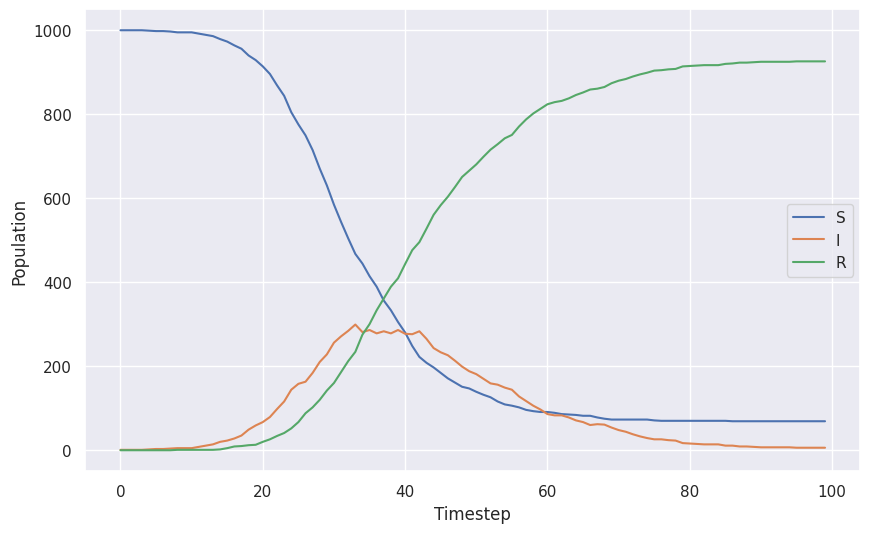

In [ ]:
plt.figure(figsize=(10, 6))
sir_sim_state = sir.compute_state(sir_sim)
plt.plot(np.sum(sir_sim_state, axis=1), label=["S", "I", "R"])
plt.xlabel("Timestep")
plt.ylabel("Population")
_ = plt.legend()


In [ ]:
epidemic_data = pd.DataFrame(tf.squeeze(sir_sim_state),columns=["S", "I", "R"])
epidemic_data

,S,I,R
0,999.0,1.0,0.0
1,999.0,1.0,0.0
2,999.0,1.0,0.0
3,999.0,1.0,0.0
4,998.0,2.0,0.0
...,...,...,...
95,69.0,6.0,925.0
96,69.0,6.0,925.0
97,69.0,6.0,925.0
98,69.0,6.0,925.0


### Solution

In [ ]:
# add the number of SI and IR transitions. This is easy because they
# comes as an output of the simulation. Otherwise this can be computed
# num_si = epidemic_data.S.diff(-1), num_si = epidemic_data.R.diff(1)
num_transitions = np.sum(sir_sim, axis = -2)

epidemic_data['num_si'] = num_transitions[:,0]
epidemic_data['num_ir'] = num_transitions[:,1]

# look at a random middle section of the data
epidemic_data.iloc[28:35,:]

,S,I,R,num_si,num_ir
28,670.0,210.0,120.0,40.0,22.0
29,630.0,228.0,142.0,46.0,18.0
30,584.0,256.0,160.0,41.0,26.0
31,543.0,271.0,186.0,39.0,26.0
32,504.0,284.0,212.0,37.0,22.0
33,467.0,299.0,234.0,23.0,41.0
34,444.0,281.0,275.0,30.0,25.0


In [ ]:
# WANT to compute the probability of transition P^{qr}

# need to compute transition rates first
si_rate, ir_rate = tf.map_fn(
    fn = lambda x: transition_rates(x[0],x[1]),
    elems = (np.arange(0,100), sir.compute_state(sir_sim)),
    dtype=(DTYPE, DTYPE)
)

In [ ]:
# examine output
si_rate[0:10], ir_rate[10:20]

(<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
 array([[0.0003],
        [0.0003],
        [0.0003],
        [0.0003],
        [0.0006],
        [0.0009],
        [0.0009],
        [0.0012],
        [0.0015],
        [0.0015]])>,
 <tf.Tensor: shape=(10, 1), dtype=float64, numpy=
 array([[0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1]])>)

In [ ]:
# add to our dataframe
epidemic_data['si_rate'] = si_rate
epidemic_data['ir_rate'] = ir_rate

epidemic_data

,S,I,R,num_si,num_ir,si_rate,ir_rate
0,999.0,1.0,0.0,0.0,0.0,0.0003,0.1
1,999.0,1.0,0.0,0.0,0.0,0.0003,0.1
2,999.0,1.0,0.0,0.0,0.0,0.0003,0.1
3,999.0,1.0,0.0,1.0,0.0,0.0003,0.1
4,998.0,2.0,0.0,1.0,0.0,0.0006,0.1
...,...,...,...,...,...,...,...
95,69.0,6.0,925.0,0.0,0.0,0.0018,0.1
96,69.0,6.0,925.0,0.0,0.0,0.0018,0.1
97,69.0,6.0,925.0,0.0,0.0,0.0018,0.1
98,69.0,6.0,925.0,0.0,0.0,0.0018,0.1


In [ ]:
# compute transition probability
epidemic_data['si_prob'] = 1 - np.exp(-si_rate)
epidemic_data['ir_prob'] = 1 - np.exp(-ir_rate)

epidemic_data

,S,I,R,num_si,num_ir,si_rate,ir_rate,si_prob,ir_prob
0,999.0,1.0,0.0,0.0,0.0,0.0003,0.1,0.000300,0.095163
1,999.0,1.0,0.0,0.0,0.0,0.0003,0.1,0.000300,0.095163
2,999.0,1.0,0.0,0.0,0.0,0.0003,0.1,0.000300,0.095163
3,999.0,1.0,0.0,1.0,0.0,0.0003,0.1,0.000300,0.095163
4,998.0,2.0,0.0,1.0,0.0,0.0006,0.1,0.000600,0.095163
...,...,...,...,...,...,...,...,...,...
95,69.0,6.0,925.0,0.0,0.0,0.0018,0.1,0.001798,0.095163
96,69.0,6.0,925.0,0.0,0.0,0.0018,0.1,0.001798,0.095163
97,69.0,6.0,925.0,0.0,0.0,0.0018,0.1,0.001798,0.095163
98,69.0,6.0,925.0,0.0,0.0,0.0018,0.1,0.001798,0.095163


Let's take stock of what we have:

1. Number of units in each state
2. Transition probability for each time step and state

This is all you need to compute the log-likelihood of a binomial random variable!

In [ ]:
def log_lik_t_si(row):
    return row.num_si * np.log(row.si_prob) + (row.S - row.num_si) * np.log(1 - row.si_prob)

def log_lik_t_ir(row):
    return row.num_ir * np.log(row.ir_prob) + (row.I - row.num_ir) * np.log(1 - row.ir_prob)

def log_lik_t(row):
    return log_lik_t_si(row) + log_lik_t_ir(row)

In [ ]:
epidemic_data['log_lik_t'] = epidemic_data.apply(log_lik_t, axis=1)

In [ ]:
print(f"log L(X|D) = {np.sum(epidemic_data.log_lik_t[:-1])}")

log L(X|D) = -6808.564032861215


## Creating a parameterized likelihood function

Performing operations in a dataframe turns out to be restrictive. The goal of model fitting is to estimate parameters based on data and so we want to be able to feed our likelihood _function_ into an optimizer (like in [INSERT LINK](the previous Likelihood I session). We saw how to use the `scipiy.optimize` function earlier so let's work with that same function.

`optimize` needs a function which it can use to evaluate different parameter values and find the minima for. This implies that we want our likelihood function to have the model parameters as inputs. It should look something like this

> `log_likelihood_fn(theta) `
>> 42.00

We will once again focus on the SIR chain binomial model. Aggregating events over the fixed time period means that our model parameters are now part of $p^{SI}_{t_s},p^{IR}_{t_s}$. Recall the formula for the transition probabilities:
\begin{align*}
p^{SI}_{t_s}&=1-e^{-\lambda^{SI}(t_s)\delta t_s} \\
p^{IR}_{t_s}&=1-e^{-\lambda^{IR}(t_s)\delta t_s}
\end{align*}
The model parameters are in the _transition rate function_ and thus _related_ to the transition probabilities through these formulas. With this in mind, let's now implement the log-likelihood function for this model.

:::{dropdown} SIR Chain binomial likelihood formula

$$
l(X|H) \propto \sum_{s = 0}^{max - 1}\left( k \log p^{SI}_{t_s} + (S_{t_s}-k)\log(1-p^{SI}_{t_s}) + j \log p^{IR}_{t_s} + (I_{t_s}-j)\log(1-p^{IR}_{t_s}) \right)
$$

:::

In [ ]:
# raw data again
epi_df = pd.DataFrame(tf.squeeze(sir_sim_state),columns=["S", "I", "R"])
epi_df

,S,I,R
0,999.0,1.0,0.0
1,999.0,1.0,0.0
2,999.0,1.0,0.0
3,999.0,1.0,0.0
4,998.0,2.0,0.0
...,...,...,...
95,69.0,6.0,925.0
96,69.0,6.0,925.0
97,69.0,6.0,925.0
98,69.0,6.0,925.0


We are going to use the a closure to create this function. More on why soon...

In [ ]:
def make_sir_chain_binom_loglik(epidemic_dataframe):
    # data processing steps - convert to array
    epi_array = np.array(epidemic_dataframe)

    # compute change in states
    num_si = np.squeeze(sir_sim[:,:,0])

    num_ir = np.squeeze(sir_sim[:,:,1])

    def sir_chain_binom_loglik(theta):
        epsilon = DTYPE(1e-9)               # hardcoded constant

        beta, gamma = theta

        # compute transition rates based on model parameters
        si_rate = beta * epi_array[:, 1] / np.sum(epi_array, axis = -1) + epsilon
        ir_rate = np.ones_like(si_rate) * gamma

        # compute transition probabilities based on transition rates
        p_si = 1 - np.exp(-si_rate)
        p_ir = 1 - np.exp(-ir_rate)


        # compute log-lik
        log_lik_si = num_si * np.log(p_si) + (epi_array[:, 0] - num_si)*np.log(1 - p_si)
        log_lik_ir = num_ir * np.log(p_ir) + (epi_array[:, 1] - num_ir)*np.log(1 - p_ir)

        log_lik = log_lik_si + log_lik_ir

        return log_lik

    return sir_chain_binom_loglik

Mathematically, likelihood functions are functions of the parameters of the model. This is why you will see them written as $L(\theta | X)$ where $X$ is the data. We are _conditioning_ on the data. Using the closure pattern here allows us to condition our likelihood on the data - fixing those values but allowing the model parameters to change.

In [ ]:
# returns the function equivalent to the mathematical form L(theta|D)
sir_chain_binom_loglik_fn = make_sir_chain_binom_loglik(epi_df)

In [ ]:
# compute the likelihood for some parameters values
print(f"log-liklihood = {np.sum(sir_chain_binom_loglik_fn([0.3, 0.1]))}")

log-liklihood = -6809.288232930216


### Sanity check!

Are the two methods the same?

In [ ]:
# same as before? No output if it does pass
np.testing.assert_almost_equal(
    actual = np.array(epidemic_data.log_lik_t),
    desired = sir_chain_binom_loglik_fn([0.3, 0.1]),
)

In [ ]:
pd.DataFrame({'function_method':sir_chain_binom_loglik_fn([0.3, 0.1]),
              'dataframe_method':np.array(epidemic_data.log_lik_t)})

,function_method,dataframe_method
0,-0.399701,-0.399701
1,-0.399701,-0.399701
2,-0.399701,-0.399701
3,-8.511276,-8.511276
4,-8.217080,-8.217080
...,...,...
95,-0.724200,-0.724200
96,-0.724200,-0.724200
97,-0.724200,-0.724200
98,-0.724200,-0.724200


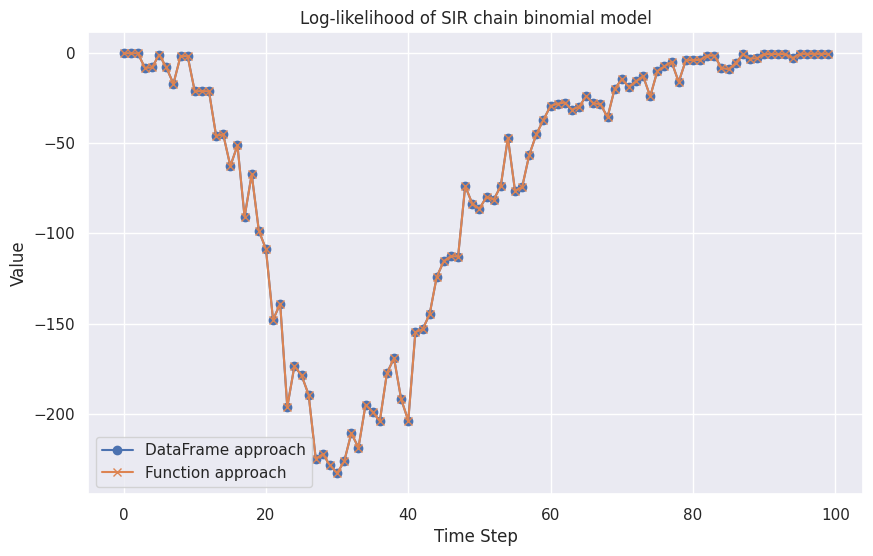

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.array(epidemic_data.log_lik_t), label='DataFrame approach', marker='o')
plt.plot(sir_chain_binom_loglik_fn((np.float64(0.3), np.float64(0.1))), label='Function approach', marker='x')

# Adding titles and labels
plt.title('Log-likelihood of SIR chain binomial model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

__Note__: numerical errors can arise. The values are close but not quite identical

### Exercise 3

Compute the MLE of the the likelihood function.

### Solution

In [ ]:
# import optimizer
from scipy.optimize import minimize

In [ ]:
ll_fn = lambda x: -np.sum(sir_chain_binom_loglik_fn(x))

In [ ]:
ll_fn([.3, 0.1])

6809.288232930216

In [ ]:
# initial values on the log scale
initial_parameters = np.array([0.1, 0.1], dtype=np.float32)

opt = minimize(
    ll_fn,
    initial_parameters,
    method="L-BFGS-B",
    jac="3-point",
    options={"finite_diff_rel_step": None},
)


In [ ]:
opt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6808.4751204384265
        x: [ 2.893e-01  1.021e-01]
      nit: 8
      jac: [ 1.561e-04  3.226e-04]
     nfev: 50
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
print(f"True values:      beta = {np.round(0.3,5)},   gamma = {np.round(0.1,5)}")
print(f"Estimated values: beta = {np.round(opt.x[0],5)}, gamma = {np.round(opt.x[1],5)}")

True values:      beta = 0.3,   gamma = 0.1
Estimated values: beta = 0.28927, gamma = 0.10211


In [ ]:
std_errors = np.sqrt(np.diagonal(opt.hess_inv.todense()))
lower_ci = (opt.x - 1.96 * std_errors)  # 95% CI
upper_ci = (opt.x + 1.96 * std_errors)

In [ ]:
print(f"Beta 95% CI:  lower = {np.round(lower_ci[0],5)}, upper = {np.round(upper_ci[0],5)}")
print(f"Gamma 95% CI: lower = {np.round(lower_ci[1],5)}, upper = {np.round(upper_ci[1],5)}")

Beta 95% CI:  lower = 0.25412, upper = 0.32442
Gamma 95% CI: lower = -0.13835, upper = 0.34258
